# LSTM AutoEncoder

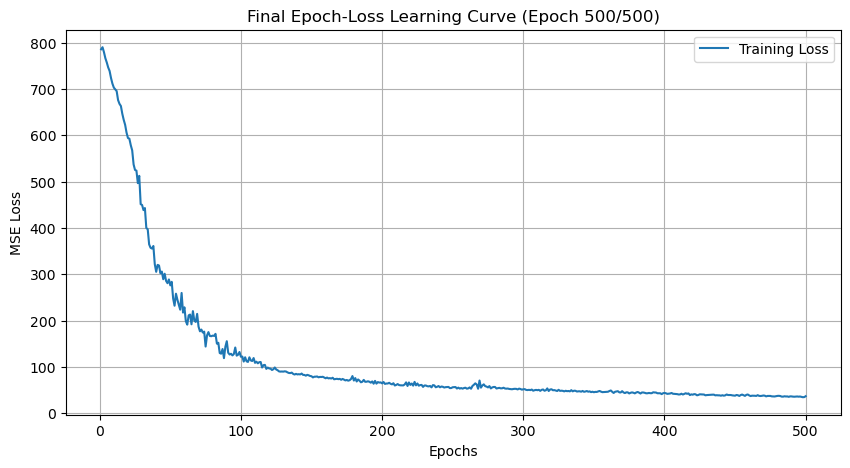


Predicting anomaly scores on test data...


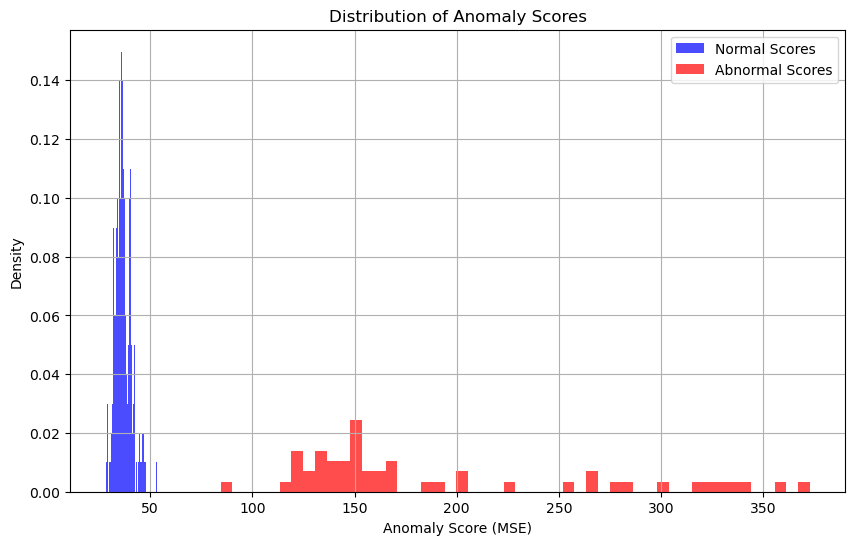

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import time

import warnings
warnings.filterwarnings("ignore")

# --- (1) & (3) 建構模型：完全遵照論文設計 ---
# Seq2Seq + AutoRegressive + Reverse Tricks

class ResInv(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        self.mu = torch.mean(x, dim = 1, keepdim=True)
        self.sigma = torch.std(x, dim = 1, keepdim=True)
        z = (x - self.mu)/self.sigma
        return z
    def denorm(self, z):
        x_hat = z*self.sigma + self.mu
        return x_hat
        

class Encoder(nn.Module):
    """
    Encoder模組：讀取反轉後的序列並輸出上下文向量 (hidden/cell states)
    """
    def __init__(self, input_dim, hidden_dim, n_layers=1):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # Reverse Trick: 反轉序列
        reversed_x = torch.flip(x, dims=[1])
        
        # LSTM forward pass
        # outputs shape: [batch_size, seq_len, hidden_dim]
        # hidden, cell shapes: [n_layers, batch_size, hidden_dim]
        outputs, (hidden, cell) = self.lstm(reversed_x)
        
        return hidden, cell

class Decoder(nn.Module):
    """
    Decoder模組：使用上下文向量和前一時間步的真實值來重建當前時間步
    """
    def __init__(self, output_dim, hidden_dim, n_layers=1):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=output_dim, # Autoregressive: input is previous step's output
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        # x shape: [batch_size, 1, output_dim] (input for a single timestep)
        # hidden, cell shapes: [n_layers, batch_size, hidden_dim]
        
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        # output shape: [batch_size, 1, hidden_dim]
        
        prediction = self.fc(output)
        # prediction shape: [batch_size, 1, output_dim]
        
        return prediction, hidden, cell

class Seq2SeqAutoencoder(nn.Module):
    """
    主模型：結合Encoder和Decoder，實現Seq2Seq自迴歸重建
    """
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.revin = ResInv()

    def forward(self, src):
        # src shape: [batch_size, seq_len, input_dim]
        src = self.revin(src)
        batch_size, seq_len, input_dim = src.shape
        
        # 用於存放decoder的輸出
        outputs = torch.zeros(batch_size, seq_len, input_dim).to(self.device)
        
        # 1. Encoder forward pass
        hidden, cell = self.encoder(src)
        
        # 2. Decoder Autoregressive loop
        # Decoder的第一個輸入是 0 向量
        decoder_input = torch.zeros(batch_size, 1, input_dim).to(self.device)
        
        # Teacher Forcing: 在每一步都使用真實數據(src)作為下一步的輸入
        for t in range(seq_len):
            decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1, :] = decoder_output
            
            # 使用真實數據的下一個時間步作為輸入
            decoder_input = src[:, t:t+1, :]
        outputs = self.revin.denorm(outputs)
        return outputs

# --- (4), (5), (6) Agent Class 設計 ---

class AnomalyDetectorAgent:
    """
    一個包含模型、訓練、預測功能的Agent
    """
    def __init__(self, input_dim, hidden_dim, n_layers, lr=1e-3, device=None):
        """
        Agent內建好模型的設定
        """
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        print(f"Using device: {self.device}")

        # 模型設定
        self.encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers).to(self.device)
        self.decoder = Decoder(output_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers).to(self.device)
        self.model = Seq2SeqAutoencoder(self.encoder, self.decoder, self.device).to(self.device)
        
        # 損失函數與優化器
        self.criterion = nn.MSELoss(reduction='none') # 先不對loss做平均，方便後續計算by-sample score
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, dataloader, epochs):
        """
        .train的input為dataloader和epochs
        會從dataloader中隨機挑一筆sample出來訓練
        每10個epoch會用plt.suplots去畫epoch-loss的Learning curve
        """
        self.model.train()
        epoch_losses = []
        
        print("Starting training...")
        start_time = time.time()
        
        for epoch in range(1, epochs + 1):
            # 從dataloader中隨機挑選一個batch進行訓練
            # 雖然效率不高，但遵照指示
            data_list = list(dataloader)
            random_batch = random.choice(data_list)
            
            src = random_batch.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(src)
            
            # 計算Loss
            loss_tensor = self.criterion(outputs, src)
            loss = loss_tensor.mean() # 在batch上取平均以進行反向傳播
            
            # Backward and optimize
            loss.backward()
            self.optimizer.step()
            
            epoch_losses.append(loss.item())

            # --- (7) & (8) 每10個epoch畫圖 ---
            if epoch % 10 == 0:
                clear_output(wait=True) # 每次畫圖前會先呼叫clear_output()
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(range(1, epoch + 1), epoch_losses, label='Training Loss')
                ax.set_title(f"Epoch-Loss Learning Curve (Epoch {epoch}/{epochs})")
                ax.set_xlabel("Epochs")
                ax.set_ylabel("MSE Loss")
                ax.legend()
                ax.grid(True)
                plt.show()

        end_time = time.time()
        print(f"Training finished in {end_time - start_time:.2f} seconds.")
        # 最終再畫一次完整的圖
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(range(1, epochs + 1), epoch_losses, label='Training Loss')
        ax.set_title(f"Final Epoch-Loss Learning Curve (Epoch {epochs}/{epochs})")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("MSE Loss")
        ax.legend()
        ax.grid(True)
        plt.show()

    def predict(self, dataloader):
        """
        .predict則是輸入dataloader，然後會給出異常分數（by sample）
        """
        self.model.eval()
        anomaly_scores = []
        
        with torch.no_grad():
            for batch in dataloader:
                src = batch.to(self.device)
                
                # 模型重建
                outputs = self.model(src)
                
                # 計算每個樣本的重建誤差（異常分數）
                # self.criterion shape: [batch_size, seq_len, features]
                errors = self.criterion(outputs, src)
                # 在seq_len和features維度上取平均，得到每個樣本的分數
                sample_scores = torch.mean(errors, dim=[1, 2])
                
                anomaly_scores.extend(sample_scores.cpu().numpy())
                
        return np.array(anomaly_scores)

# --- (10) 主程式 ---

# 數據生成器 (由您提供)
def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

# 自定義Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        # 將數據轉換為 float32 的 tensor
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 主程式執行區塊
if __name__ == '__main__':
    # 1. 產生數據
    N_train_normal = 1000
    N_test_normal = 200
    N_test_abnormal = 50

    train_data = np.array([normal_data_generator() for _ in range(N_train_normal)])
    
    test_normal_data = np.array([normal_data_generator() for _ in range(N_test_normal)])
    test_abnormal_data = np.array([abnormal_data_generator() for _ in range(N_test_abnormal)])
    
    # 合併測試數據並創建標籤
    test_data = np.concatenate([test_normal_data, test_abnormal_data], axis=0)
    test_labels = np.array([0] * N_test_normal + [1] * N_test_abnormal)

    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    
    # 2. 創建Dataset和DataLoader
    train_dataset = TimeSeriesDataset(train_data)
    test_dataset = TimeSeriesDataset(test_data)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # 3. 建構並訓練Agent
    # 從數據中獲取維度信息
    seq_len, input_dim = train_data.shape[1], train_data.shape[2]
    
    # 建立Agent，latent_dim(即hidden_dim)可以自行調整
    agent = AnomalyDetectorAgent(
        input_dim=input_dim, 
        hidden_dim=32,      # Latent dimension
        n_layers=1,         # LSTM層數
        lr=1e-3
    )
    
    # 訓練模型
    agent.train(dataloader=train_loader, epochs=500)

    # 4. 進行預測並獲取異常分數
    print("\nPredicting anomaly scores on test data...")
    anomaly_scores = agent.predict(dataloader=test_loader)
    
    # 5. 畫出正常/異常樣本的分數分佈圖
    normal_scores = anomaly_scores[test_labels == 0]
    abnormal_scores = anomaly_scores[test_labels == 1]
    
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Scores', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Scores', color='red', density=True)
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score (MSE)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1DCNN AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import warnings

# 忽略 Matplotlib 可能產生的 UserWarning
warnings.filterwarnings("ignore")

class ResInv(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        self.mu = torch.mean(x, dim = 1, keepdim=True)
        self.sigma = torch.std(x, dim = 1, keepdim=True)
        z = (x - self.mu)/self.sigma
        return z
    def denorm(self, z):
        x_hat = z*self.sigma + self.mu
        return x_hat
        

# --- 1. 模型架構 (1D CNN Seq2Seq Autoregressive AutoEncoder) ---
class Seq2SeqCNNAutoencoder(nn.Module):
    """
    採用 1D CNN 作為 Encoder，GRU 作為 Autoregressive Decoder 的 Seq2Seq Autoencoder。
    完全遵循論文中用於時間序列重建的非監督式學習設計。
    """
    def __init__(self, input_dim, seq_len, latent_dim, cnn_out_channels=64):
        super(Seq2SeqCNNAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.cnn_out_channels = cnn_out_channels

        # Encoder: 使用 1D CNN 提取特徵
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=16, kernel_size=7, padding=3),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2), # seq_len / 2
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=7, padding=3),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2)  # seq_len / 4
        )
        
        # 計算 CNN 輸出後的維度，以接入全連接層
        encoder_output_len = seq_len // 4
        self.encoder_fc = nn.Linear(32 * encoder_output_len, latent_dim)

        # Decoder: 使用 GRU 進行自迴歸解碼
        self.decoder_gru = nn.GRU(input_size=input_dim, hidden_size=latent_dim, batch_first=True)
        self.decoder_fc = nn.Linear(latent_dim, input_dim)
        self.ResInv = ResInv()

    def forward(self, x, teacher_forcing_ratio=0.5):
        """
        x 的維度: (batch_size, seq_len, input_dim)
        """
        x = self.ResInv(x)
        batch_size = x.size(0)
        
        # --- Encoder ---
        # CNN 輸入維度要求 (batch_size, channels, length)
        # channels 即為 input_dim, length 即為 seq_len
        x_encoded = x.permute(0, 2, 1)
        x_encoded = self.encoder_cnn(x_encoded)
        x_encoded = x_encoded.view(batch_size, -1)
        
        # 潛在向量 z，作為 Decoder 的初始隱狀態
        z = self.encoder_fc(x_encoded)
        hidden = z.unsqueeze(0) # GRU 要求 (num_layers, batch, hidden_size)

        # --- Decoder ---
        # 初始化輸出 Tensor
        outputs = torch.zeros_like(x)
        # Decoder 的第一個輸入，通常是一個 "start" token，這裡簡化為 0
        decoder_input = torch.zeros(batch_size, self.input_dim, device=x.device)

        # 自迴歸地生成序列
        for t in range(self.seq_len):
            # GRU 輸入維度 (batch_size, seq_len=1, input_size)
            decoder_output, hidden = self.decoder_gru(decoder_input.unsqueeze(1), hidden)
            
            # 全連接層輸出預測值
            output = self.decoder_fc(decoder_output.squeeze(1))
            outputs[:, t, :] = output

            # 決定是否使用 Teacher Forcing
            use_teacher_forcing = random.random() < teacher_forcing_ratio
            if use_teacher_forcing:
                # 下一個輸入是真實值
                decoder_input = x[:, t, :]
            else:
                # 下一個輸入是模型剛生成的預測值
                decoder_input = output.detach() # 使用 detach() 避免梯度回傳影響
        outputs = self.ResInv.denorm(outputs)
        return outputs

# --- 2. Agent 類別 ---
class AnomalyDetectionAgent:
    """
    一個 Agent 來管理模型、訓練過程和預測。
    內建了模型的設定。
    """
    def __init__(self, seq_len, input_dim, latent_dim=32, lr=1e-3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # 模型設定
        self.model = Seq2SeqCNNAutoencoder(
            input_dim=input_dim,
            seq_len=seq_len,
            latent_dim=latent_dim
        ).to(self.device)
        
        # 優化器與損失函數
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none') # 使用 'none' 以便後續計算 per-sample score

    def train(self, train_loader, epochs):
        """
        訓練模型
        Input:
            train_loader: 訓練數據的 DataLoader
            epochs: 訓練週期數
        """
        self.model.train()
        epoch_losses = []
        
        print("Starting training...")
        for epoch in range(epochs):
            total_loss = 0
            for batch_data in train_loader:
                # DataLoader 輸出的是一個 list，取出裡面的 tensor
                batch_data = batch_data[0].to(self.device)
                
                self.optimizer.zero_grad()
                
                # 前向傳播 (在訓練時使用 Teacher Forcing)
                reconstructions = self.model(batch_data, teacher_forcing_ratio=0.5)
                
                # 計算損失 (在此處取 mean)
                loss = self.criterion(reconstructions, batch_data).mean()
                
                # 反向傳播與優化
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            epoch_losses.append(avg_loss)
            
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

            # 每 10 個 epoch 畫出 Learning Curve
            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(range(1, epoch + 2), epoch_losses, marker='o', linestyle='-')
                ax.set_title(f"Learning Curve (Epoch {epoch+1})")
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Average MSE Loss")
                ax.grid(True)
                plt.show()
        
        print("Training finished.")
        # 最終再畫一次完整的圖
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-')
        ax.set_title(f"Final Learning Curve (Epoch {epochs})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Average MSE Loss")
        ax.grid(True)
        plt.show()


    def predict(self, data_loader):
        """
        使用訓練好的模型進行預測，並返回每個樣本的異常分數。
        Input:
            data_loader: 欲預測的數據 DataLoader
        Output:
            Numpy array of anomaly scores for each sample.
        """
        self.model.eval()
        anomaly_scores = []
        
        with torch.no_grad():
            for batch_data in data_loader:
                batch_data = batch_data[0].to(self.device)
                
                # 預測時不使用 Teacher Forcing
                reconstructions = self.model(batch_data, teacher_forcing_ratio=0.0)
                
                # 計算每個樣本的重建誤差（異常分數）
                loss_matrix = self.criterion(reconstructions, batch_data)
                # 在 seq_len 和 input_dim 維度上取平均，得到每個樣本的分數
                scores = torch.mean(loss_matrix, dim=(1, 2))
                
                anomaly_scores.extend(scores.cpu().numpy())
                
        return np.array(anomaly_scores)

# --- 3. 數據生成器 (由您提供) ---
def normal_data_generator():    
    # 第一段 48分鐘    
    base = float(np.random.normal(60, 2, size = (1, )))    
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()    
    
    base = float(np.random.normal(70, 2, size = (1, )))    
    series2_1 = ([base]*48).copy()    
    
    # 第二段 52分鐘    
    base = float(np.random.normal(-20, 2, size = (1, )))    
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()    
    
    base = float(np.random.normal(60, 2, size = (1, )))    
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()    
    
    # 第三段 30分鐘    
    base = float(np.random.normal(60, 2, size = (1, )))    
    series1_3 = ([base]*30).copy()    
    
    series1 = series1_1 + series1_2 + series1_3    
    series2 = series2_1 + series2_2    
    flag = float(np.random.normal(0, .5, size = (1, )))    
    if flag > .5:    
        return np.vstack([series1, series2]).T    
    else:    
        return np.vstack([series2, series1]).T    

def abnormal_data_generator():    
    base = float(np.random.normal(60, 2, size = (1, )))    
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()    
    
    base = float(np.random.normal(60, 2, size = (1, )))    
    series2_1 = ([base]*48).copy()    
    base = float(np.random.normal(-20, 2, size = (1, )))    
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()    
    base = float(np.random.normal(60, 2, size = (1, )))    
    series2_3 = ([base]*30).copy()    
    series2 = series2_1 + series2_2 + series2_3    
    
    flag = float(np.random.normal(0, .5, size = (1, )))    
    if flag > .5:    
        return np.vstack([series1, series2]).T    
    else:    
        return np.vstack([series2, series1]).T

# --- 4. 主程式 ---
if __name__ == '__main__':
    # --- 資料準備 ---
    print("Generating data...")
    SEQ_LEN = 48 + 52 + 30 # 130
    N_FEATURES = 2
    
    # 產生訓練資料 (只有正常樣本)
    N_TRAIN = 2000
    train_data = np.array([normal_data_generator() for _ in range(N_TRAIN)], dtype=np.float32)
    train_tensor = torch.from_numpy(train_data)
    train_dataset = TensorDataset(train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    # 產生測試資料 (正常與異常樣本混合)
    N_TEST_NORMAL = 200
    N_TEST_ABNORMAL = 50
    test_normal_data = np.array([normal_data_generator() for _ in range(N_TEST_NORMAL)], dtype=np.float32)
    test_abnormal_data = np.array([abnormal_data_generator() for _ in range(N_TEST_ABNORMAL)], dtype=np.float32)
    
    # 合併測試資料並建立標籤
    test_data = np.vstack([test_normal_data, test_abnormal_data])
    test_labels = np.array([0] * N_TEST_NORMAL + [1] * N_TEST_ABNORMAL) # 0: normal, 1: abnormal
    
    test_tensor = torch.from_numpy(test_data)
    test_dataset = TensorDataset(test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    print("Data generation complete.")
    
    # --- 建立 Agent 並進行訓練 ---
    agent = AnomalyDetectionAgent(
        seq_len=SEQ_LEN,
        input_dim=N_FEATURES,
        latent_dim=16, # 潛在維度可調整
        lr=1e-3
    )
    
    agent.train(train_loader, epochs=500) # 訓練 50 個週期
    
    # --- 進行預測並評估結果 ---
    print("\nPredicting on test data...")
    anomaly_scores = agent.predict(test_loader)
    
    # 分離正常與異常樣本的分數
    normal_scores = anomaly_scores[test_labels == 0]
    abnormal_scores = anomaly_scores[test_labels == 1]
    
    # --- 視覺化異常分數分佈 ---
    plt.figure(figsize=(12, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Scores', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Scores', color='red', density=True)
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Reconstruction Error (Anomaly Score)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nAverage score for normal data: {np.mean(normal_scores):.4f}")
    print(f"Average score for abnormal data: {np.mean(abnormal_scores):.4f}")

Generating data...
Data generation complete.
Using device: cuda
Starting training...
Epoch [1/500], Loss: 752.588261



KeyboardInterrupt



# Dense AutoEncoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import time

# --- (1) & (3) 建構模型：全Dense AutoEncoder ---
warnings.filterwarnings("ignore")

class ResInv(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        self.mu = torch.mean(x, dim = 1, keepdim=True)
        self.sigma = torch.std(x, dim = 1, keepdim=True)
        z = (x - self.mu)/self.sigma
        return z
    def denorm(self, z):
        x_hat = z*self.sigma + self.mu
        return x_hat

class DenseAutoencoder(nn.Module):
    """
    全密集層(Fully-Dense)的Autoencoder模型
    """
    def __init__(self, seq_len, input_dim, latent_dim=32, hidden_dims=[128, 64]):
        super(DenseAutoencoder, self).__init__()
        
        # 保存維度信息，用於展平和重塑
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.flattened_dim = seq_len * input_dim
        
        # --- Encoder ---
        encoder_layers = []
        in_dim = self.flattened_dim
        # 動態建立隱藏層
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            in_dim = h_dim
        # 最後一層到潛在空間
        encoder_layers.append(nn.Linear(in_dim, latent_dim))
        encoder_layers.append(nn.ReLU()) # 進入潛在空間前也使用ReLU
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # --- Decoder ---
        decoder_layers = []
        # 反轉隱藏層維度
        in_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(in_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            in_dim = h_dim
        # 最後一層到輸出
        decoder_layers.append(nn.Linear(in_dim, self.flattened_dim))
        # 輸出層不加激活函數，以重建任意值的原始數據
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.ResInv = ResInv()

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # 1. 展平輸入
        x = self.ResInv(x)
        flattened_x = x.view(x.size(0), -1)
        
        # 2. Encoder: 壓縮到潛在空間
        latent_vector = self.encoder(flattened_x)
        
        # 3. Decoder: 從潛在空間重建
        reconstructed_flat = self.decoder(latent_vector)
        
        # 4. 重塑回原始序列形狀
        reconstructed_x = reconstructed_flat.view(x.size(0), self.seq_len, self.input_dim)
        reconstructed_x = self.ResInv.denorm(reconstructed_x)
        
        return reconstructed_x

# --- (4), (5), (6) Agent Class 設計 ---

class AnomalyDetectorAgent:
    """
    一個包含模型、訓練、預測功能的Agent
    """
    def __init__(self, seq_len, input_dim, latent_dim, hidden_dims, lr=1e-3, device=None):
        """
        Agent內建好模型的設定
        """
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        print(f"Using device: {self.device}")

        # 模型設定
        self.model = DenseAutoencoder(
            seq_len=seq_len,
            input_dim=input_dim,
            latent_dim=latent_dim,
            hidden_dims=hidden_dims
        ).to(self.device)
        
        # 損失函數與優化器
        self.criterion = nn.MSELoss(reduction='none') # 先不對loss做平均，方便後續計算by-sample score
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def train(self, dataloader, epochs):
        """
        .train的input為dataloader和epochs
        會從dataloader中隨機挑一筆sample出來訓練
        每10個epoch會用plt.suplots去畫epoch-loss的Learning curve
        """
        self.model.train()
        epoch_losses = []
        
        print("Starting training...")
        start_time = time.time()
        
        for epoch in range(1, epochs + 1):
            # 從dataloader中隨機挑選一個batch進行訓練
            data_list = list(dataloader)
            random_batch = random.choice(data_list)
            
            src = random_batch.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(src)
            
            # 計算Loss
            loss_tensor = self.criterion(outputs, src)
            loss = loss_tensor.mean() # 在batch上取平均以進行反向傳播
            
            # Backward and optimize
            loss.backward()
            self.optimizer.step()
            
            epoch_losses.append(loss.item())

            # --- (7) & (8) 每10個epoch畫圖 ---
            if epoch % 10 == 0:
                clear_output(wait=True) # 每次畫圖前會先呼叫clear_output()
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(range(1, epoch + 1), epoch_losses, label='Training Loss')
                ax.set_title(f"Epoch-Loss Learning Curve (Epoch {epoch}/{epochs})")
                ax.set_xlabel("Epochs")
                ax.set_ylabel("MSE Loss")
                ax.legend()
                ax.grid(True)
                plt.show()

        end_time = time.time()
        print(f"Training finished in {end_time - start_time:.2f} seconds.")
        # 最終再畫一次完整的圖
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(range(1, epochs + 1), epoch_losses, label='Training Loss')
        ax.set_title(f"Final Epoch-Loss Learning Curve (Epoch {epochs}/{epochs})")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("MSE Loss")
        ax.legend()
        ax.grid(True)
        plt.show()

    def predict(self, dataloader):
        """
        .predict則是輸入dataloader，然後會給出異常分數（by sample）
        """
        self.model.eval()
        anomaly_scores = []
        
        with torch.no_grad():
            for batch in dataloader:
                src = batch.to(self.device)
                
                # 模型重建
                outputs = self.model(src)
                
                # 計算每個樣本的重建誤差（異常分數）
                # self.criterion shape: [batch_size, seq_len, features]
                errors = self.criterion(outputs, src)
                # 在seq_len和features維度上取平均，得到每個樣本的分數
                sample_scores = torch.mean(errors, dim=[1, 2])
                
                anomaly_scores.extend(sample_scores.cpu().numpy())
                
        return np.array(anomaly_scores)

# --- (10) 主程式 ---

# 數據生成器 (由您提供)
def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

# 自定義Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        # 將數據轉換為 float32 的 tensor
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 主程式執行區塊
if __name__ == '__main__':
    # 1. 產生數據
    N_train_normal = 1000
    N_test_normal = 200
    N_test_abnormal = 50

    train_data = np.array([normal_data_generator() for _ in range(N_train_normal)])
    
    test_normal_data = np.array([normal_data_generator() for _ in range(N_test_normal)])
    test_abnormal_data = np.array([abnormal_data_generator() for _ in range(N_test_abnormal)])
    
    # 合併測試數據並創建標籤
    test_data = np.concatenate([test_normal_data, test_abnormal_data], axis=0)
    test_labels = np.array([0] * N_test_normal + [1] * N_test_abnormal)

    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    
    # 2. 創建Dataset和DataLoader
    train_dataset = TimeSeriesDataset(train_data)
    test_dataset = TimeSeriesDataset(test_data)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # 3. 建構並訓練Agent
    # 從數據中獲取維度信息
    seq_len, input_dim = train_data.shape[1], train_data.shape[2]
    
    # 建立Agent，可以自行調整各層設定
    agent = AnomalyDetectorAgent(
        seq_len=seq_len,
        input_dim=input_dim, 
        latent_dim=16,                # 潛在空間維度
        hidden_dims=[128, 64, 32],    # Encoder/Decoder隱藏層維度
        lr=1e-4                       # 學習率
    )
    
    # 訓練模型
    agent.train(dataloader=train_loader, epochs=300)

    # 4. 進行預測並獲取異常分數
    print("\nPredicting anomaly scores on test data...")
    anomaly_scores = agent.predict(dataloader=test_loader)
    
    # 5. 畫出正常/異常樣本的分數分佈圖
    normal_scores = anomaly_scores[test_labels == 0]
    abnormal_scores = anomaly_scores[test_labels == 1]
    
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Scores', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Scores', color='red', density=True)
    plt.title('Distribution of Anomaly Scores (Dense Autoencoder)')
    plt.xlabel('Anomaly Score (MSE)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()